# A simple Transfer learning project

In this project, we demonstrate the principle of transfert learning; The repurposing of existing neural networks for new projects.

Deep neural networks can be expensive and time-consuming to train, with costs ranging from millions of dollars to processing times that can span months. However, the primary challenge lies in accessing the necessary data. Large companies, such as Google, often train their neural networks using proprietary data, which is closely guarded and constitutes the cornerstone of their flagship products, like Google's search engine.

With the advent of transfer learning, willing corporations such as Google can share fully trained models without compromising their data. Existing networks can therefore be downloaded by the little guys and be cut, twisted and modified at will, saving tons of time and money!

In this project, we will download EfficientNet B7, a convolutional network which, at the time, was known for its outstanding performance on computer vision tasks. The EfficientNet we donwload today was trained on datasets with thousands of labels, ranging from cats and dogs to cars and buildings.

We will repurpose this instance of EfficientNet to work as a vehicle classification module.

## The core principle
The classical transfer learning method and the one we will use is to cut the classification tail of a network and replace it with another model.

![Replacing the classification tail A with a neural network B.](./image/vgg-transfer-learning.png)

The new appendage only needs a few seconds to a few hours of training to be operational. In this project, we will compare the use of different models as the appendage.

**Terminology alert!**
After removing the tail of our neural network, we call the last layer the "feature map" (see the above image). It is a bunch of raw neurons, each representing a high-level *feature*, or a concept. For instance, a given neuron's activation can represent the presence of fur-like texture in the image, which in addition with other neurons would indicate the presence of a cat in the picture.

Now that we are done with the theory, **let's get started!**

## Get the data
For all intents and purposes, all you need to know is that we separate our data into training, testing, and validation datasets, with `X` as the input (raw image: red, green, blue), and `y` as the label ('bike', 'car', 'truck', ...). *You may skip the rest of this section.*

For curious readers, we retrieve our data from a folder structured as such: <br> ![File structure for the project](./image/file-structure.png)

The data is already segregated into train, test, and validation sets, with each set containing a folder for each class. It is an unusual way to store the data. To retrieve our images from those folders we use...
- `os.path.join(*args)` to create a platform-agnostic filepath (Linux and Windows): <br> ![Join folder names into a full path](./image/mypath.png)

- `os.path.split(string)` to get the label, contained as the parent folder name of our images: <br> ![Split path name to keep the label](./image/split-image.png)

- `glob` to search for all possible files, using the `*` wildcard: <br> ![Finding all files in data\train\bike](./image/wildcard-glob.png)

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import split, join
from PIL import Image
from glob import glob

In [63]:
def get_data(paths):
    images = [np.array(Image.open(path)) for path in paths]
    labels = [split(split(path)[0])[1] for path in paths]
    return np.array(images), np.array(labels)

In [72]:
X_train, y_train = get_data(glob(join('data', 'train', '*', '*')))
X_test, y_test =   get_data(glob(join('data', 'test', '*', '*'))) 
X_valid, y_valid = get_data(glob(join('data', 'valid', '*', '*'))) 

In [73]:
print('     	 X                               y' )
print('train:\t', X_train.shape, X_train.dtype, '\t', y_train.shape, y_train.dtype )
print('test:\t',  X_test.shape, X_test.dtype,   '\t', y_test.shape, y_test.dtype)
print('valid:\t', X_valid.shape, X_valid.dtype, '\t', y_valid.shape, y_valid.dtype)

     	 X                               y
train:	 (280, 256, 256, 3) uint8 	 (280,) <U10
test:	 (50, 256, 256, 3) uint8 	 (50,) <U10
valid:	 (139, 256, 256, 3) uint8 	 (139,) <U10


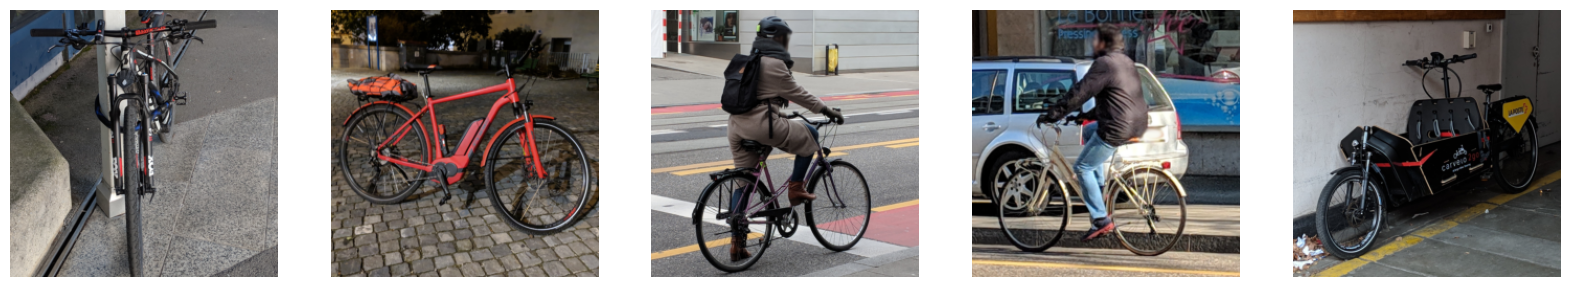

In [74]:
fig, axes = plt.subplots(1, 5, figsize=(20,20))
[(axes[i].imshow(img), axes[i].axis('off'), ) for i, img in enumerate(X_train[0:5])]
plt.show()

## Preprocess the data
We prepare the data for training.
- The data is ordered, starting with bikes, cars, motorcycles ... We will shuffle the data to obtain a homogeneous training set, so the model doesn't suffer from **order bias**.
- Images are stored as RGB, with each color having a value within [0;255]. Neural Networks work better with normalized data [0;1].
- Labels are textual, however, neural networks work with floating-point numbers. We will encode labels: 'bike -> 0'
- All values fed to the neural network must be floating points. Labels can formatted as integers, but the output of the network will be as floating points, so let keep it as such.



In [75]:
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

In [76]:
# Shuffle.
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)
X_valid, y_valid = shuffle(X_valid, y_valid, random_state=0)

In [77]:
# Normalize.
X_train, X_test, X_valid = [(x)/255. for x in [X_train, X_test, X_valid]]
[(x.mean(), x.std(), x.min(), x.max()) for x in [X_train, X_test, X_valid]]

[(0.35457985159395966, 0.2352760946900631, 0.0, 1.0),
 (0.33193211255042376, 0.23457991338072745, 0.0, 1.0),
 (0.3512715323203296, 0.23815648599462888, 0.0, 1.0)]

In [78]:
# Encode labels.
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
y_valid = encoder.transform(y_valid)
dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

{'bike': 0, 'car': 1, 'motorcycle': 2, 'other': 3, 'truck': 4, 'van': 5}

In [80]:
# Format to float.
X_train, X_test, X_valid = [x.astype('float32') for x in [X_train, X_test, X_valid]]
y_train, y_test, y_valid = [y.astype('float32') for y in [y_train, y_test, y_valid]]
X_train.dtype, y_train.dtype

(dtype('float32'), dtype('float32'))

## Download and run [_EfficientNet_ B7](https://paperswithcode.com/paper/fixing-the-train-test-resolution-discrepancy-2)
At the time of working on this project, in 2020/04/28, [_EfficientNet_ B7](https://paperswithcode.com/paper/fixing-the-train-test-resolution-discrepancy-2) was two days old. It had one order of magnitude less parameters than the previous record holder (66M vs 556M parameters).

Note: We advise working with a later version of tensorflow (2.10.0) with GPU enabled on Windows machines.